In [1]:
import jax.numpy as jnp
import jax
from ripple import get_eff_pads, get_match_arr
from tqdm import tqdm

import numpy as np
from ripple import ms_to_Mc_eta, Mc_eta_to_ms
import lalsimulation as lalsim
import lal

import matplotlib.pyplot as plt
from jax.config import config

config.update("jax_enable_x64", True)

/home/nnarenraju/Research/ORChiD/DEBUGGING/ML-GWSC1-Glasgow/source/baseline/.venv/lib64/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/tmp/ipykernel_1093821/2401134406.py:12: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


  0%|          | 0/1000 [00:00<?, ?it/s]

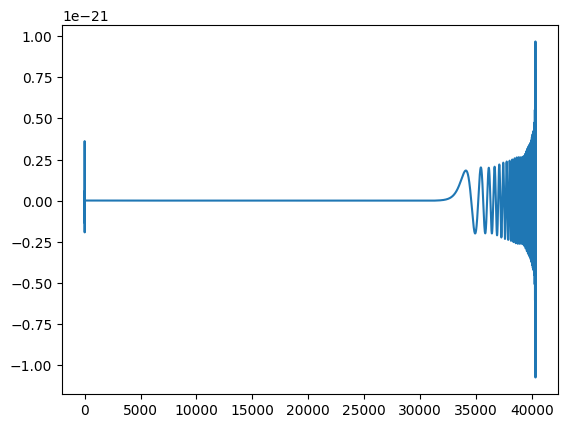

  0%|          | 0/1000 [00:04<?, ?it/s]

9.8427734375


RuntimeError: No active exception to reraise

In [22]:
def random_match_waveforms(n, IMRphenom):
    # Get a frequency domain waveform
    f_l = 16
    f_u = 1024
    T = 20
    if IMRphenom == "IMRPhenomD":
        from ripple.waveforms.IMRPhenomD import (
            gen_IMRPhenomD_hphc as waveform_generator,
        )
    if IMRphenom == "IMRPhenomXAS":
        from ripple.waveforms.IMRPhenomXAS import (
            gen_IMRPhenomXAS_hphc as waveform_generator,
        )
    if IMRphenom == "IMRPhenomPv2":
        from ripple.waveforms.IMRPhenomPv2 import (
            gen_IMRPhenomPv2_hphc as waveform_generator,
        )
    f_sampling = 4096
    delta_t = 1 / f_sampling
    tlen = int(round(T / delta_t))
    freqs = np.fft.rfftfreq(tlen, delta_t)
    df = freqs[1] - freqs[0]
    fs = freqs[(freqs > f_l) & (freqs < f_u)]
    f_ref = f_l

    @jax.jit
    def waveform(theta):
        hp, _ = waveform_generator(fs, theta, f_ref)
        return hp

    # Get a frequency domain waveform
    thetas = []
    matches = []
    f_ASD, ASD = np.loadtxt("O3Livingston.txt", unpack=True)

    if "PhenomP" in IMRphenom:
        for i in tqdm(range(n)):
            precessing_matchmaking(
                IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
            )
    else:
        for i in tqdm(range(n)):
            non_precessing_matchmaking(
                IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
            )

    thetas = np.array(thetas)
    matches = np.array(matches)
    # print(thetas, matches)
    print("Mean match:", np.mean(matches))
    print("Median match:", np.median(matches))
    print("Minimum match:", np.min(matches))

    return None


def non_precessing_matchmaking(
    IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
):
    m1 = np.random.uniform(1.0, 100.0)
    m2 = np.random.uniform(1.0, 100.0)
    s1 = np.random.uniform(-1.0, 1.0)
    s2 = np.random.uniform(-1.0, 1.0)

    tc = 0.0
    phic = 0.0
    dist_mpc = 440
    inclination = np.pi / 2.0
    phi_ref = 0.0

    if m1 < m2:
        theta = np.array([m2, m1, s2, s1, dist_mpc, tc, phic, inclination])
    elif m1 > m2:
        theta = np.array([m1, m2, s1, s2, dist_mpc, tc, phic, inclination])
    else:
        raise ValueError("Something went wrong with the parameters")
    approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

    f_ref = f_l
    m1_kg = theta[0] * lal.MSUN_SI
    m2_kg = theta[1] * lal.MSUN_SI
    distance = dist_mpc * 1e6 * lal.PC_SI

    hp, _ = lalsim.SimInspiralChooseFDWaveform(
        m1_kg,
        m2_kg,
        0.0,
        0.0,
        theta[2],
        0.0,
        0.0,
        theta[3],
        distance,
        inclination,
        phi_ref,
        0,
        0.0,
        0.0,
        df,
        f_l,
        f_u,
        f_ref,
        None,
        approximant,
    )
    freqs_lal = np.arange(len(hp.data.data)) * df

    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

    theta_ripple = np.array(
        [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
    )
    hp_ripple = waveform(theta_ripple)
    pad_low, pad_high = get_eff_pads(fs)
    PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

    mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
    hp_lalsuite = hp.data.data[mask_lal]
    matches.append(
        get_match_arr(
            pad_low,
            pad_high,
            # np.ones_like(fs) * 1.0e-42,
            PSD_vals,
            hp_ripple,
            hp_lalsuite,
        )
    )
    thetas.append(theta)


def precessing_matchmaking(
    IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
):
    m1 = np.random.uniform(1.0, 100.0)
    m2 = np.random.uniform(1.0, 100.0)
    m1 = 20.0
    m2 = 19.0
    s1_amp = np.random.uniform(0.0, 1.0)
    s2_amp = np.random.uniform(0.0, 1.0)
    s1_phi = np.random.uniform(0, 2 * np.pi)
    s2_phi = np.random.uniform(0, 2 * np.pi)
    s1_thetahelper = np.random.uniform(0, 1)
    s2_thetahelper = np.random.uniform(0, 1)
    s1_theta = np.arccos(1 - 2 * s1_thetahelper)
    s2_theta = np.arccos(1 - 2 * s2_thetahelper)
    # translate that into cartesian
    s1x = s1_amp * np.sin(s1_theta) * np.cos(s1_phi)
    s1y = s1_amp * np.sin(s1_theta) * np.sin(s1_phi)
    s1z = s1_amp * np.cos(s1_theta)

    s2x = s2_amp * np.sin(s2_theta) * np.cos(s2_phi)
    s2y = s2_amp * np.sin(s2_theta) * np.sin(s2_phi)
    s2z = s2_amp * np.cos(s2_theta)

    tc = 0.0
    phic = 0.0
    dist_mpc = 440
    inclination = np.pi / 2.0
    phi_ref = 0

    if m1 < m2:
        theta = np.array(
            [m2, m1, s2x, s2y, s2z, s1x, s1y, s1z, dist_mpc, tc, phi_ref, inclination]
        )
    elif m1 > m2:
        theta = np.array(
            [m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, dist_mpc, tc, phi_ref, inclination]
        )
    else:
        raise ValueError("Something went wrong with the parameters")
    approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

    f_ref = f_l
    m1_kg = theta[0] * lal.MSUN_SI
    m2_kg = theta[1] * lal.MSUN_SI
    distance = dist_mpc * 1e6 * lal.PC_SI

    hp, _ = lalsim.SimInspiralChooseFDWaveform(
        m1_kg,
        m2_kg,
        theta[2],
        theta[3],
        theta[4],
        theta[5],
        theta[6],
        theta[7],
        distance,
        inclination,
        phi_ref,
        0,
        0.0,
        0.0,
        df,
        f_l,
        f_u,
        f_ref,
        None,
        approximant,
    )
    freqs_lal = np.arange(len(hp.data.data)) * df

    Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
    theta_ripple = np.array(
        [
            Mc,
            eta,
            theta[2],
            theta[3],
            theta[4],
            theta[5],
            theta[6],
            theta[7],
            dist_mpc,
            tc,
            phic,
            inclination,
        ]
    )
    hp_ripple = waveform(theta_ripple)

    hp_ripple_td = np.fft.irfft(hp_ripple) / (1./4096.)
    plt.plot(hp_ripple_td)
    plt.show()
    print(len(hp_ripple_td)/4096.)
    raise


    pad_low, pad_high = get_eff_pads(fs)
    PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

    mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
    hp_lalsuite = hp.data.data[mask_lal]
    matches.append(
        get_match_arr(
            pad_low,
            pad_high,
            # np.ones_like(fs) * 1.0e-42,
            PSD_vals,
            hp_ripple,
            hp_lalsuite,
        )
    )
    thetas.append(theta)


if __name__ == "__main__":
    # Choose from "IMRPhenomD", "IMRPhenomXAS", "IMRPhenomPv2"
    random_match_waveforms(1000, "IMRPhenomPv2")
    None